In [69]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

from ipywidgets import interact 

#Modelo
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [179]:
df = pd.read_csv('data/Modelar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df.shape[0])
print("Número de variables: %d" % df.shape[1])
if df.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')

Tamaño del conjunto de datos:  103230
Número de variables: 55
El índice es único.


In [180]:
def process_cadastralquality(value):
    dic = {'A': 11, 'B': 10, 'C': 9}
    if value in dic:
        return dic[value]
    else:
        try:
            return 9 - int(value)
        except ValueError:
            return np.nan
        
def process_cadastral(df):
    df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(process_cadastralquality)

In [181]:
process_cadastral(df)

In [182]:
df = df.dropna()

In [183]:
X = df.drop(columns=['CLASE']).copy()
y = df['CLASE'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, shuffle=True, random_state=10)

df_modelar = X_train.merge(y_train, on='ID')
df_modelar_new = X_val.merge(y_val, on='ID')

print("Tamaño del conjunto de datos disponibles: ", len(df_modelar))
print("Tamaño del conjunto de nuevos datos: ", len(df_modelar_new))

Tamaño del conjunto de datos disponibles:  87728
Tamaño del conjunto de nuevos datos:  15482


In [184]:
list_class_order = ['RESIDENTIAL', 'PUBLIC', 'RETAIL', 'OFFICE', 'INDUSTRIAL', 'AGRICULTURE', 'OTHER']

## Distancia al centro

In [185]:
center_x = df_modelar['X'].sum()/len(df_modelar['X'])
center_y = df_modelar['Y'].sum()/len(df_modelar['Y'])

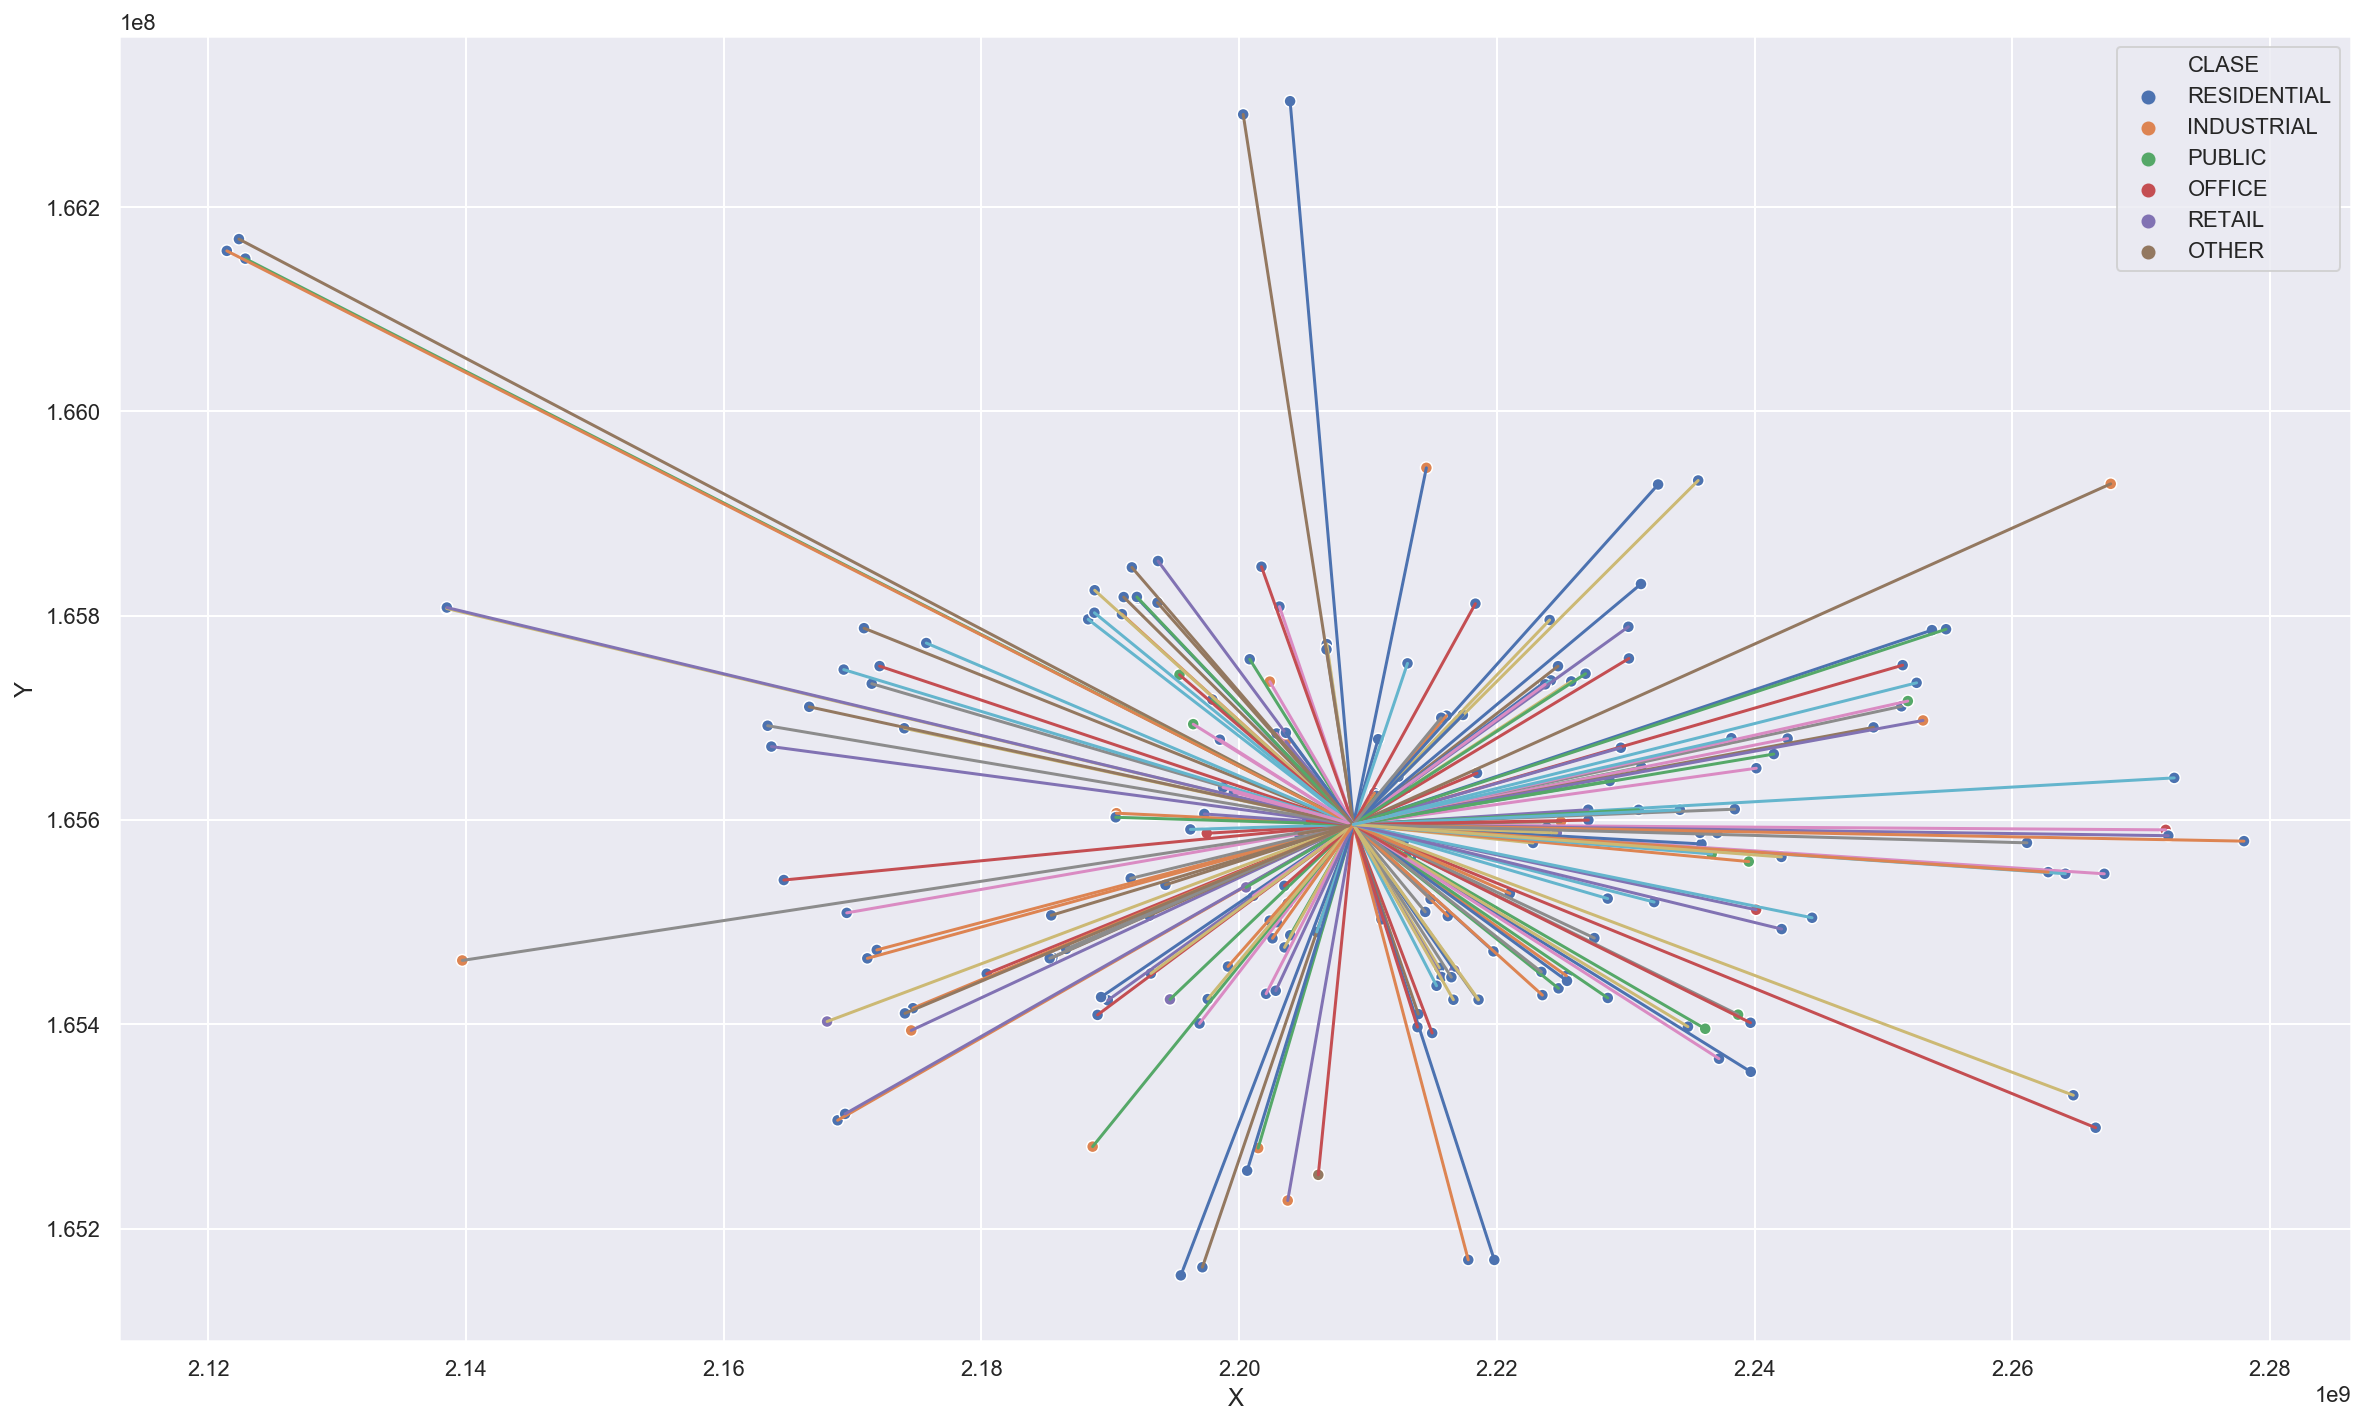

In [11]:
plt.figure(figsize=(20,12))
for i in range(200):
    point1 = [df_modelar.iloc[i]['X'], df_modelar.iloc[i]['Y']]
    point2 = [center_x, center_y]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values)
sns.scatterplot(df_modelar['X'][:200], df_modelar['Y'][:200], hue=df_modelar['CLASE'][:200])

In [186]:
def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

In [187]:
df_modelar['distance_to_center'] = df_modelar.apply(lambda r: distance([r['X'], r['Y']], [center_x, center_y]), axis=1)

In [188]:
df_modelar['distance_to_center'] = df_modelar['distance_to_center'] / df_modelar['distance_to_center'].max() #Normalizamos 0,1

In [189]:
df_modelar.groupby('CLASE')['distance_to_center'].mean()

CLASE
AGRICULTURE    0.348430
INDUSTRIAL     0.372862
OFFICE         0.183858
OTHER          0.213616
PUBLIC         0.226200
RESIDENTIAL    0.230438
RETAIL         0.230114
Name: distance_to_center, dtype: float64

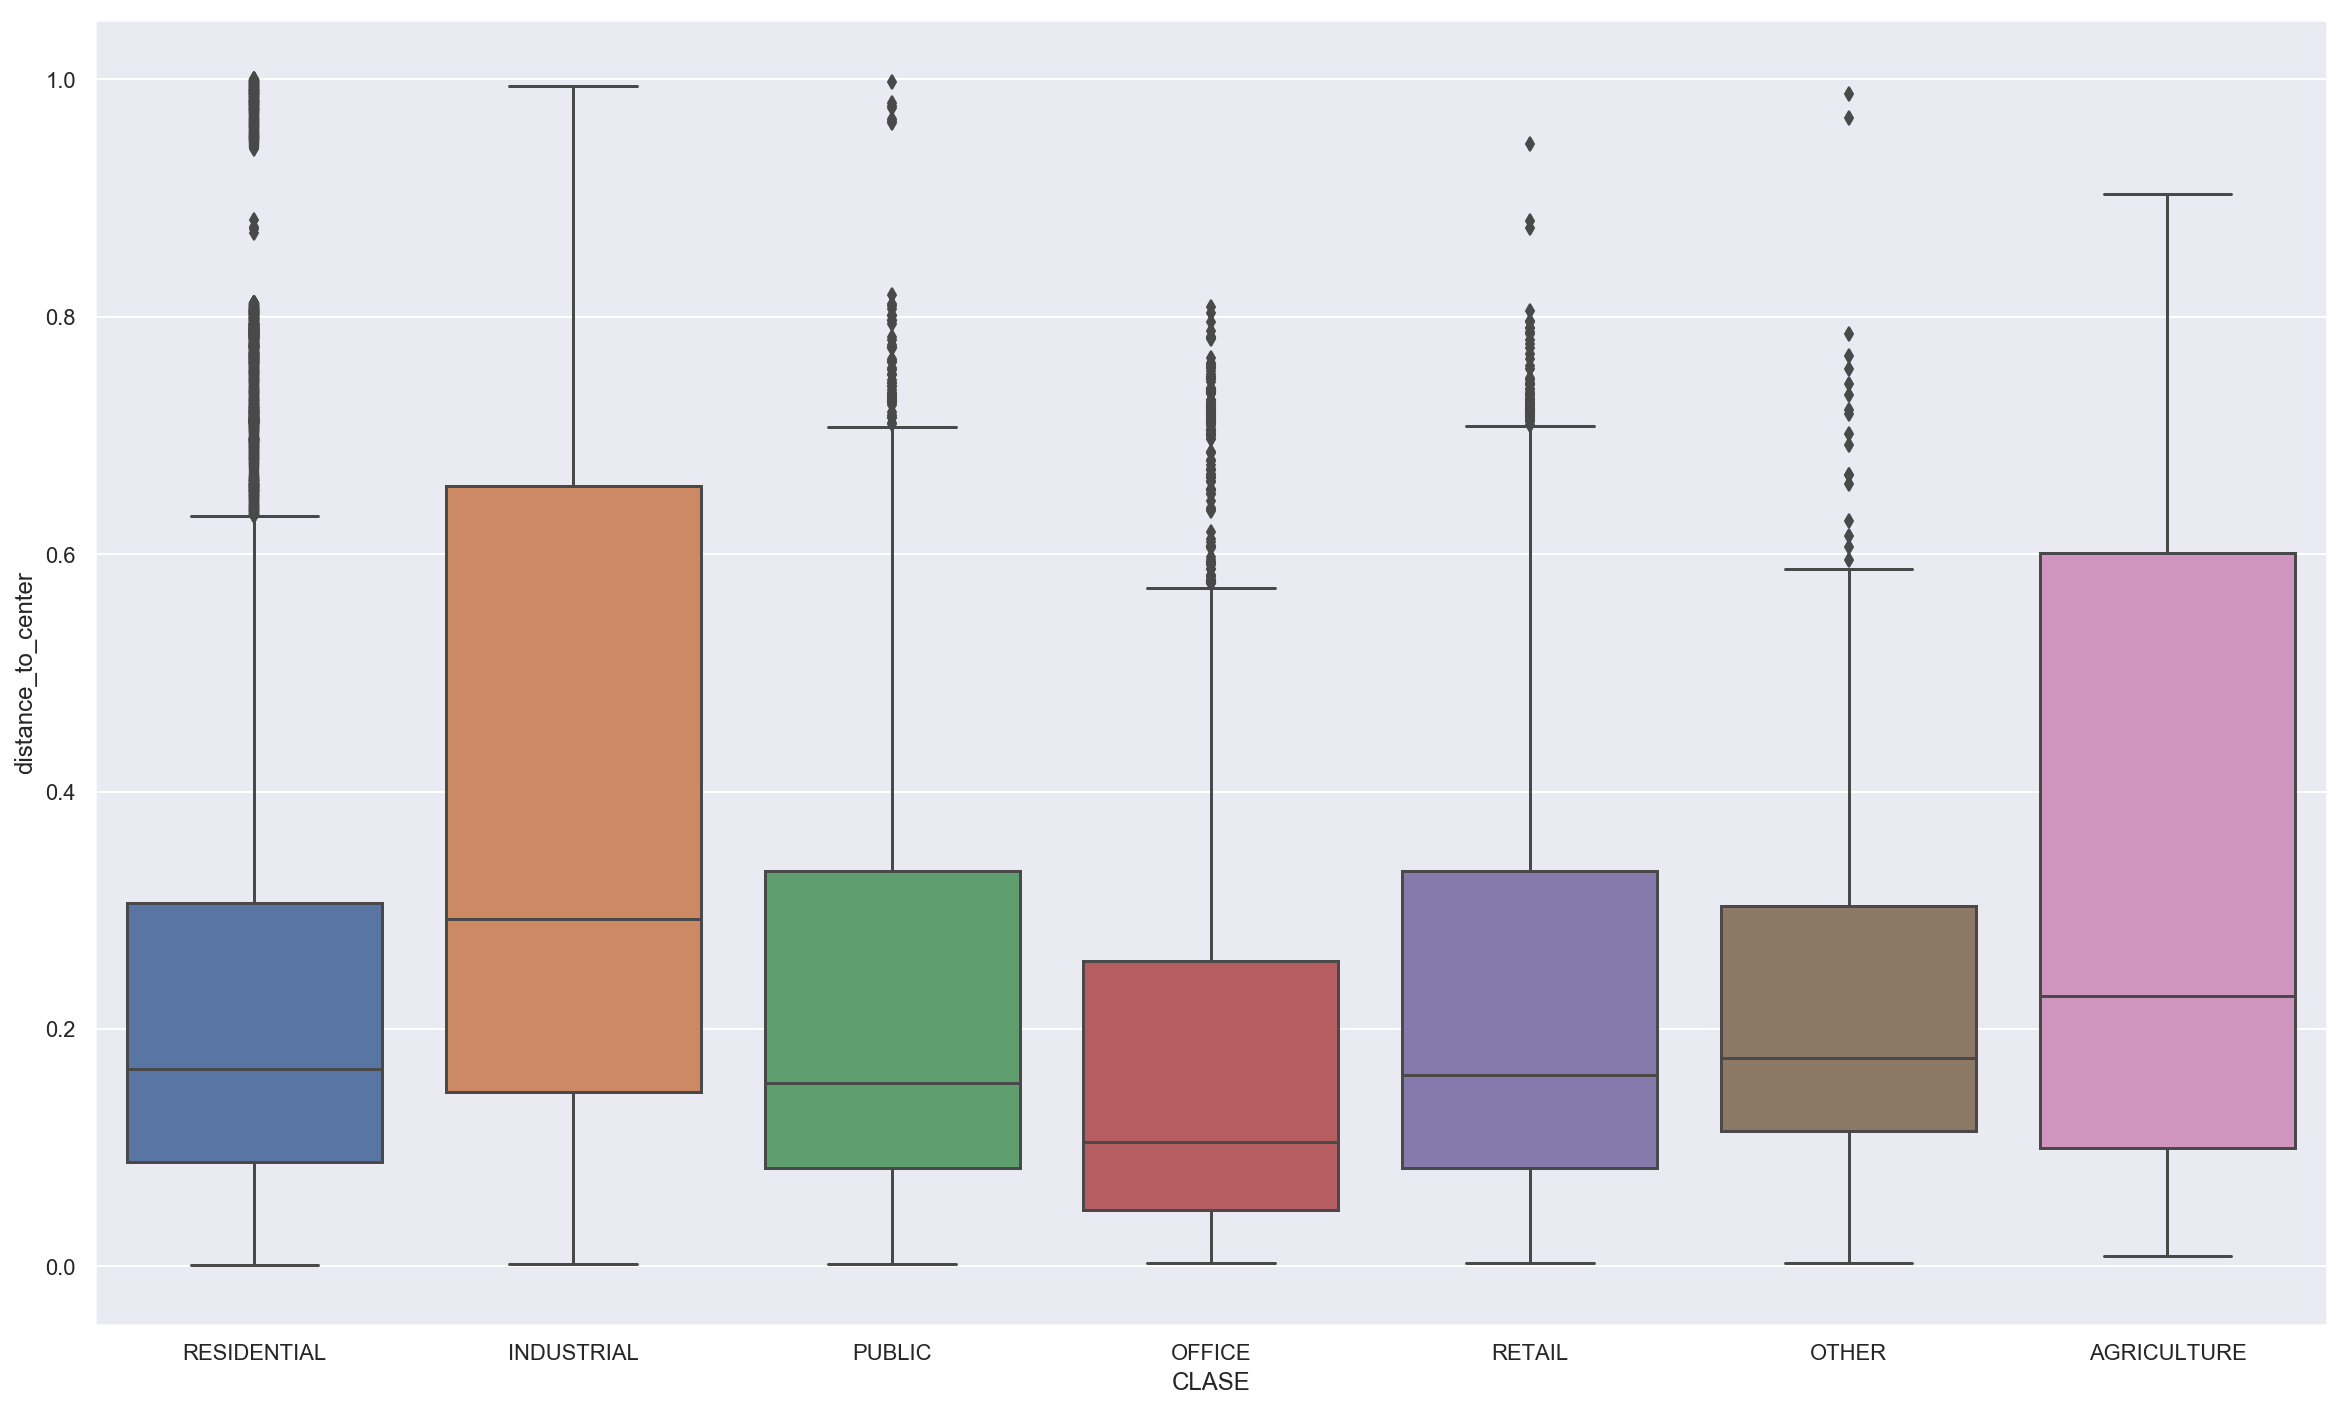

In [190]:
plt.figure(figsize=(20,12))
sns.boxplot(x="CLASE", y="distance_to_center", data=df_modelar)

## Densidad de vecinos

# Cambiar por kneighbours porque en el test no tenemos las clases

In [14]:
def get_n_neighbours(registry, n):
    index = registry.index
    d = registry['distance_to_center']
    neighbours = df_modelar.loc[np.abs(df_modelar[~df_modelar.index.isin(index)]['distance_to_center'] - d).nsmallest(n).index]
    return neighbours['CLASE']

In [15]:
def process_density(registry, n):
    neighbours = get_n_neighbours(registry, n)
    result = neighbours.value_counts()
    for c in result.index:
        registry[c] = result[c] # / result.values.sum() Para probabilidades
    return registry

In [ ]:
index_min_distance = np.abs(
        df_modelar[~df_modelar.index.isin(['BFDE3E366A78561C'])]['distance_to_center'] - df_modelar.loc['BFDE3E366A78561C']['distance_to_center']) \
                    .nsmallest(10).index
df_modelar.loc[index_min_distance]['CLASE'].value_counts()

In [ ]:
df_modelar[(df_modelar['distance_to_center'] < df_modelar.loc['BFDE3E366A78561C']['distance_to_center']+0.001) & 
           (df_modelar['distance_to_center'] > df_modelar.loc['BFDE3E366A78561C']['distance_to_center']-0.001)]['CLASE'].value_counts()

In [74]:
aux = process_density(X_test.iloc[0], 5)

In [75]:
aux

distance_to_center    0.118204
RESIDENTIAL           3.000000
OFFICE                1.000000
PUBLIC                1.000000
Name: 45C44E3E0FECCB0E, dtype: float64

In [ ]:
aux = df_modelar[df_modelar.CLASE=='RESIDENTIAL'][:200].apply(lambda r: process_density(r, 4), axis=1)

In [ ]:
aux[df_modelar.CLASE.unique()].sum()

In [146]:
from sklearn.neighbors import KNeighborsClassifier

X = df_modelar[['X', 'Y']].copy()
y = df_modelar['CLASE'].copy()

n = 5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)
neigh = KNeighborsClassifier(n_neighbors=n, weights='uniform')
neigh.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [147]:
y_pred = neigh.predict(X_test)
y_prob = neigh.predict_proba(X_test)

In [148]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 AGRICULTURE       0.74      0.35      0.48        82
  INDUSTRIAL       0.74      0.51      0.60      1144
      OFFICE       0.54      0.14      0.22       466
       OTHER       0.57      0.06      0.11       340
      PUBLIC       0.60      0.09      0.16       759
 RESIDENTIAL       0.91      0.99      0.95     22995
      RETAIL       0.62      0.07      0.13       533

    accuracy                           0.90     26319
   macro avg       0.67      0.32      0.38     26319
weighted avg       0.87      0.90      0.87     26319



In [149]:
y_prob

array([[0. , 0. , 0. , ..., 0. , 1. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.8, 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.2, 0.8, 0. ],
       [0. , 0.2, 0. , ..., 0. , 0.8, 0. ],
       [0. , 0. , 0. , ..., 0. , 0.6, 0. ]])

In [150]:
aux = pd.DataFrame(y_prob*n, columns=neigh.classes_, index=X_test.index)

In [151]:
aux_2 = X_test.merge(aux, on='ID', how='inner')

In [152]:
aux_2[neigh.classes_].sum()

AGRICULTURE       245.0
INDUSTRIAL       5238.0
OFFICE           2074.0
OTHER            1561.0
PUBLIC           3335.0
RESIDENTIAL    116525.0
RETAIL           2617.0
dtype: float64

In [153]:
import pickle
pickle.dump(neigh, open('./knn_CCG.model', 'wb'))

---

In [154]:
predict = neigh.predict_proba(df_modelar[['X', 'Y']])

In [155]:
aux = pd.DataFrame(predict*n, columns=[ 'C_'+c for c in neigh.classes_ ], index=df_modelar.index)
df_modelar = df_modelar.merge(aux, on='ID', how='inner')

In [156]:
df_modelar[df_modelar['C_RESIDENTIAL'] == 0].head()

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,CADASTRALQUALITYID,CLASE,distance_to_center,C_AGRICULTURE,C_INDUSTRIAL,C_OFFICE,C_OTHER,C_PUBLIC,C_RESIDENTIAL,C_RETAIL
ID,,,,,,,,,,,,,,,,,,,,,
1651F739A134EBA5,2267642951,165929091,0.001099,454.999338,573.005005,668.002612,752.999573,853.000122,1005.999158,1201.701685,...,3.0,INDUSTRIAL,0.667046,0.0,3.0,0.0,0.0,0.0,0.0,2.0
56F6582774B1F6D0,2195369233,165742204,0.000002,231.701132,364.409589,504.999207,639.999060,776.001587,922.001599,1093.998840,...,3.0,PUBLIC,0.153178,0.0,0.0,0.0,0.0,1.0,0.0,4.0
709C5E7A5C666EDF,2188630957,165280208,0.000014,633.000177,725.999939,804.000043,886.997424,980.000610,1083.000000,1205.999426,...,3.0,INDUSTRIAL,0.229666,0.0,4.0,1.0,0.0,0.0,0.0,0.0
18582CEDDDC7DBFD,2262347937,165626508,0.000035,584.000409,717.000000,859.998175,1016.000500,1205.998169,1459.001050,1728.995251,...,5.0,OFFICE,0.606945,0.0,2.0,2.0,1.0,0.0,0.0,0.0
60D1796FDDEDE6C4,2143677891,165455306,0.000000,274.999353,416.001074,561.002997,706.001086,862.001343,1040.000391,1266.006592,...,6.0,INDUSTRIAL,0.739794,0.0,4.0,1.0,0.0,0.0,0.0,0.0


In [191]:
df_modelar.drop(columns=['X', 'Y'], inplace=True)

In [192]:
#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('scaler', StandardScaler())])

#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_minsait_trans = ColumnTransformer(transformers=[('num', num_transformer, df_modelar.select_dtypes(include=np.number).columns.tolist())])

In [193]:
df_modelar['SUBCLASE'] = (df_modelar['CLASE'] == 'RESIDENTIAL').astype(int)

In [194]:
#Para nuestro primer modelo vamos a usar todas las variables
X = df_modelar.drop(columns=['CLASE', 'SUBCLASE']).copy()
y = df_modelar['SUBCLASE'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [195]:
X_train.columns

Index(['Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4',
       'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9',
       'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3',
       'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8',
       'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2',
       'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7',
       'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1',
       'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5',
       'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9',
       'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4',
       'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID',
       'distance_to_center'],
      dtype='object')

In [214]:
import xgboost as xgb
rfc_p_model = xgb.XGBClassifier(random_state=10)
underSampling = RandomUnderSampler('majority', random_state=10)
smote = SMOTE('minority', random_state=10)

parameters = {
    'clas__max_depth': [10],
    'clas__scale_pos_weight': [1]
}

minsait_pipe_rfc_p = Pipeline(steps=[('prep', df_minsait_trans), ('smt', smote), ('clas', rfc_p_model)])

GSR_p = GridSearchCV(minsait_pipe_rfc_p, parameters, cv=5, n_jobs=-1, scoring='f1', refit=True, verbose=1)
GSR_p.fit(X_train, y_train)
    
print("Mejor score: ", GSR_p.best_score_)
print("Mejore configuración de parámetros: ", GSR_p.best_params_)

minsait_pipe_rfc_p = GSR_p.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Mejor score:  0.9574272638977442
Mejore configuración de parámetros:  {'clas__max_depth': 10, 'clas__scale_pos_weight': 1}


In [215]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados")
    print('Accuracy: {}'.format(round(accuracy_score(y, y_pred), 3)))

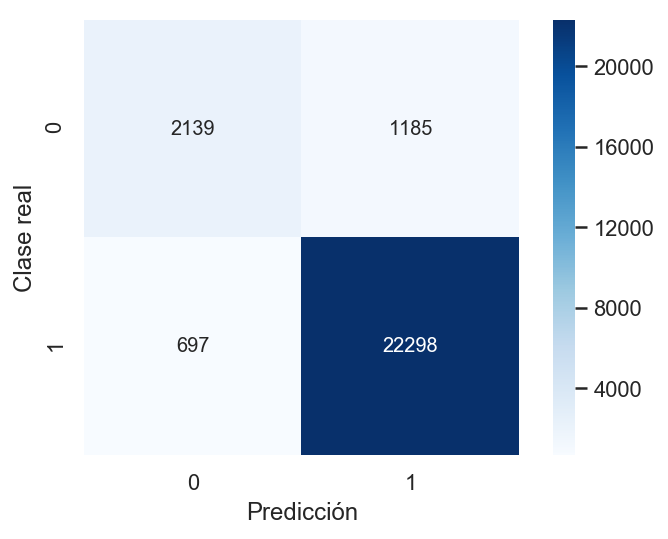

Resultados
Accuracy: 0.928


In [216]:
y_pred = minsait_pipe_rfc_p.predict(X_test)
show_results(y_test, y_pred)

In [217]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.64      0.69      3324
           1       0.95      0.97      0.96     22995

    accuracy                           0.93     26319
   macro avg       0.85      0.81      0.83     26319
weighted avg       0.92      0.93      0.93     26319



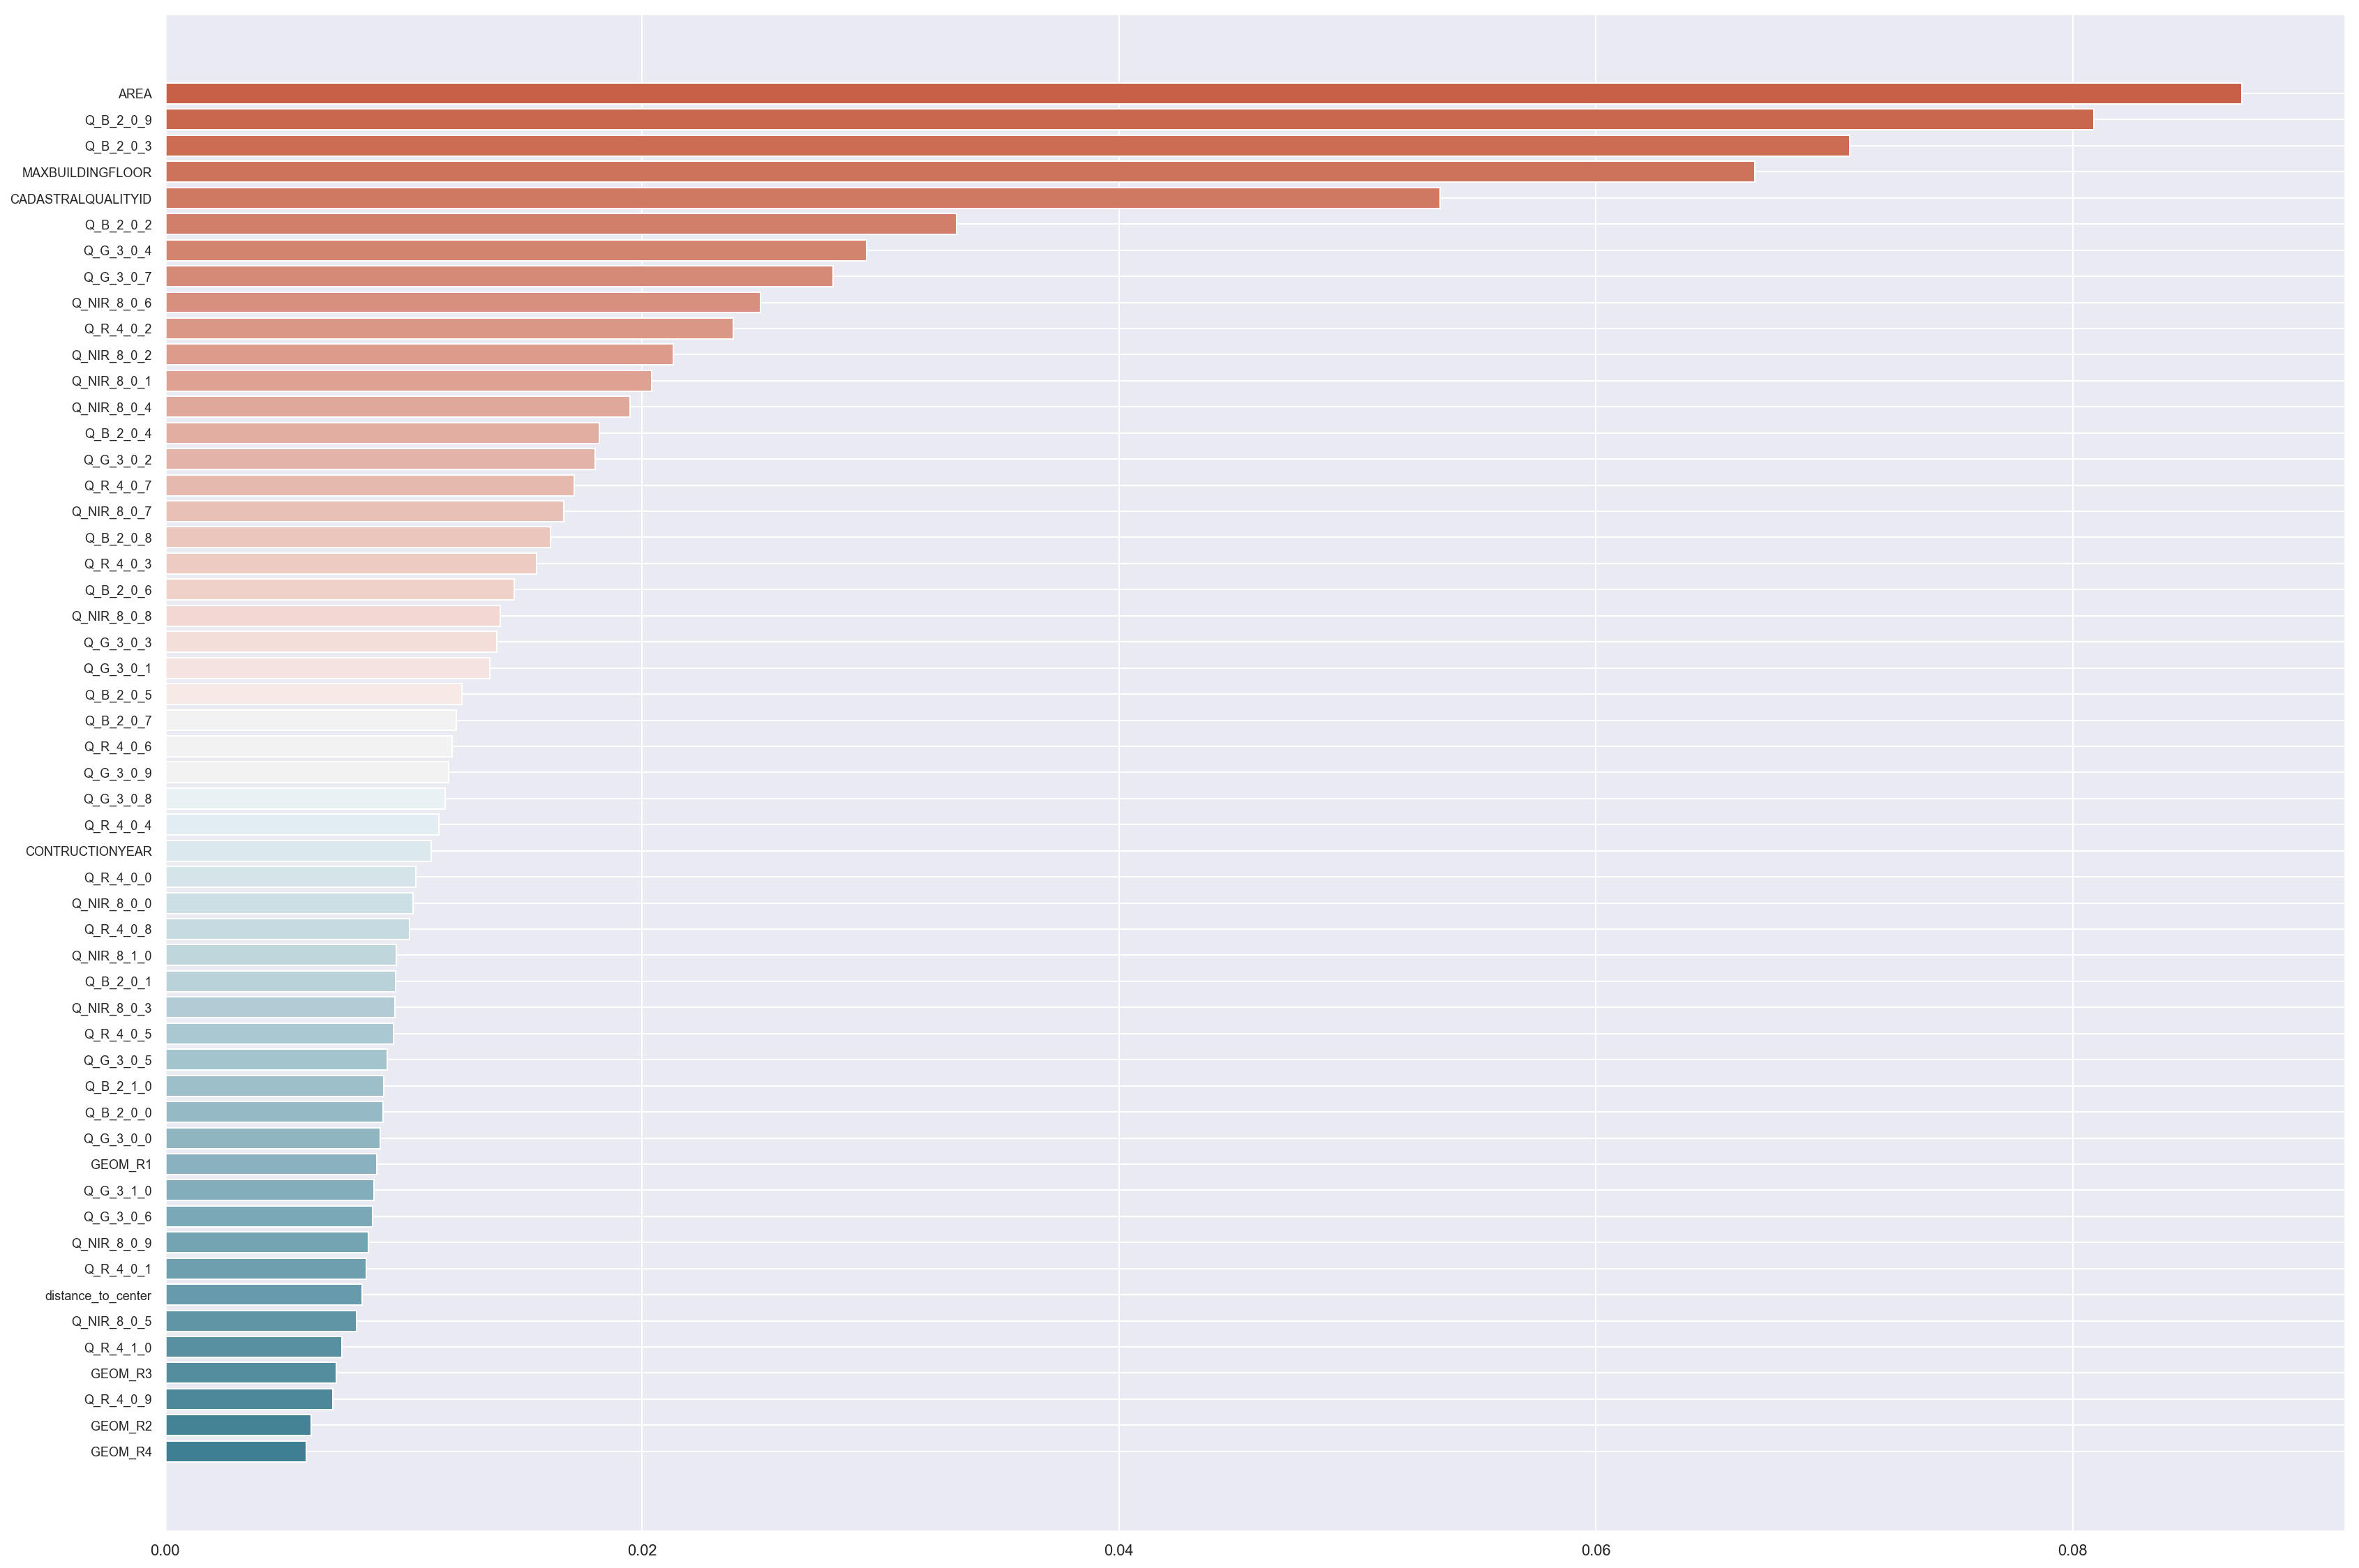

In [218]:
importances = minsait_pipe_rfc_p['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.barh(range(df_modelar.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=55),align='center')
plt.yticks(range(df_modelar.shape[1]-2), X_test.columns[ranking], fontsize=9)
plt.show()

In [219]:
import pickle
pickle.dump(minsait_pipe_rfc_p, open('binary_xgboost_CCG.model', 'wb'))

---

# MULTIETIQUETA

In [220]:
y_pred_train = minsait_pipe_rfc_p.predict(X_train)

In [221]:
X_multi = df_modelar.loc[X_train[y_pred_train==0].index.tolist()].drop(columns=['CLASE', 'SUBCLASE']).copy()
y_multi = df_modelar.loc[X_train[y_pred_train==0].index.tolist()]['CLASE'].copy()

In [222]:
y_multi.value_counts()

INDUSTRIAL     2301
PUBLIC         1375
OFFICE          796
RETAIL          784
OTHER           684
RESIDENTIAL     651
AGRICULTURE     186
Name: CLASE, dtype: int64

In [223]:
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.3, random_state=10)
#smt = SMOTE('not majority', random_state=10)

In [224]:
X_train_multi.columns

Index(['Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4',
       'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9',
       'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3',
       'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8',
       'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2',
       'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7',
       'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1',
       'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5',
       'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9',
       'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4',
       'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID',
       'distance_to_center'],
      dtype='object')

In [225]:
model = RandomForestClassifier(random_state=10)

parameters = {}
parameters['clas__max_depth'] = [5, 10, 20] #Quitamos None para que no sobreajuste al conjunto de train y que no pueda hacer la profundidad que el modelo desee. 
                                            # Lo forzamos a ponerle profundidad, como máximo 20, aunque se podría establecer mayor profundidad pero no queremos que sobreajute a los datos del train.
parameters['clas__n_estimators'] = [100, 200]
parameters['clas__class_weight'] = ['balanced']

pipe = Pipeline(steps=[('prep', df_minsait_trans),('clas', model)])
GS = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
GS.fit(X_train_multi, y_train_multi)
print(f"Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

model_multilabel = GS.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.5s finished


Mejor score:  0.5627302556988701
Mejore configuración de parámetros:  {'clas__class_weight': 'balanced', 'clas__max_depth': 20, 'clas__n_estimators': 100}


In [226]:
y_pred_multi = model_multilabel.predict(X_test_multi)
print(classification_report(y_test_multi, y_pred_multi))

              precision    recall  f1-score   support

 AGRICULTURE       0.78      0.70      0.74        67
  INDUSTRIAL       0.68      0.76      0.72       677
      OFFICE       0.44      0.41      0.42       254
       OTHER       0.62      0.57      0.59       223
      PUBLIC       0.50      0.61      0.55       388
 RESIDENTIAL       0.26      0.19      0.22       176
      RETAIL       0.51      0.36      0.42       249

    accuracy                           0.57      2034
   macro avg       0.54      0.51      0.52      2034
weighted avg       0.56      0.57      0.56      2034



In [227]:
print(confusion_matrix(y_test_multi, y_pred_multi))

[[ 47   8   2   0   6   1   3]
 [  6 517  38  12  45  16  43]
 [  0  69 103   5  44  18  15]
 [  1  32   5 126  45   8   6]
 [  3  43  32  31 237  32  10]
 [  3  40  22  13  55  33  10]
 [  0  46  32  16  45  20  90]]


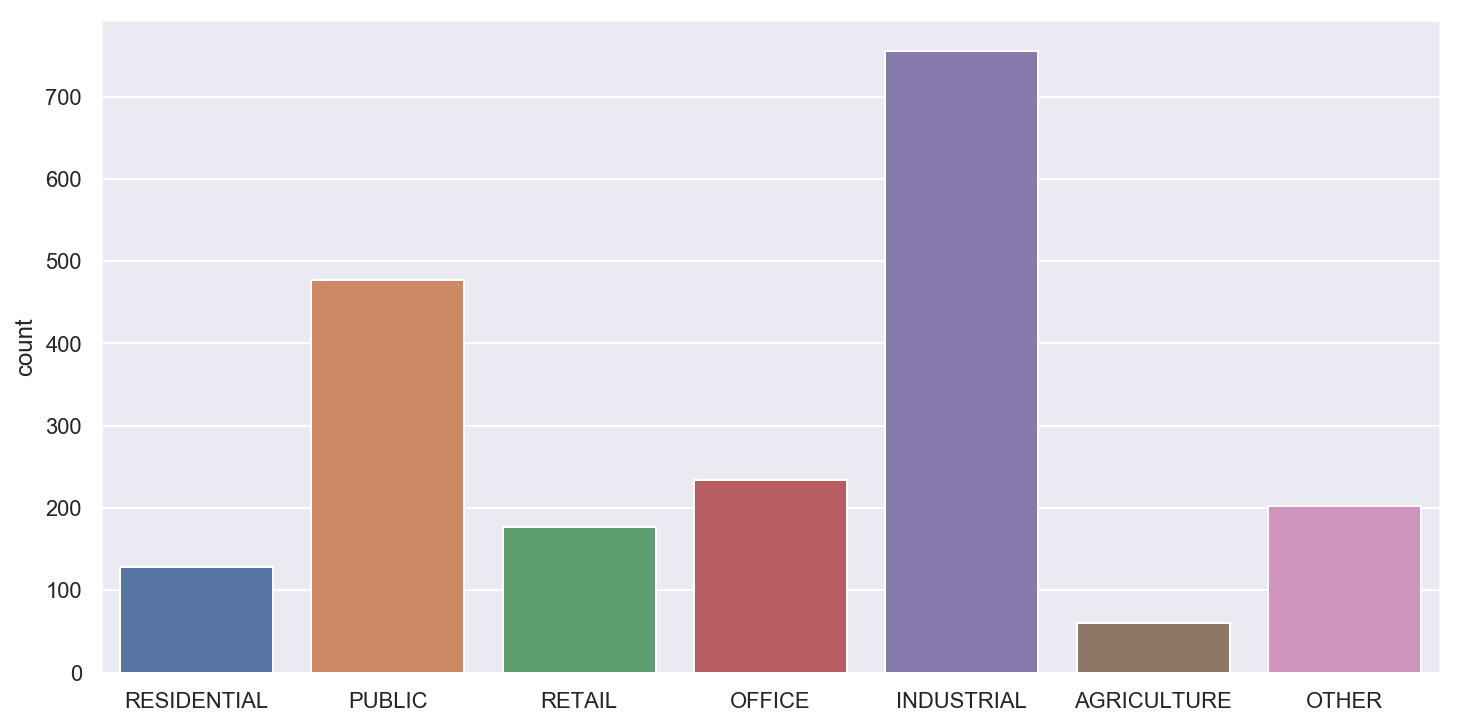

In [228]:
plt.figure(figsize=(12,6))
sns.countplot(y_pred_multi, order=list_class_order);

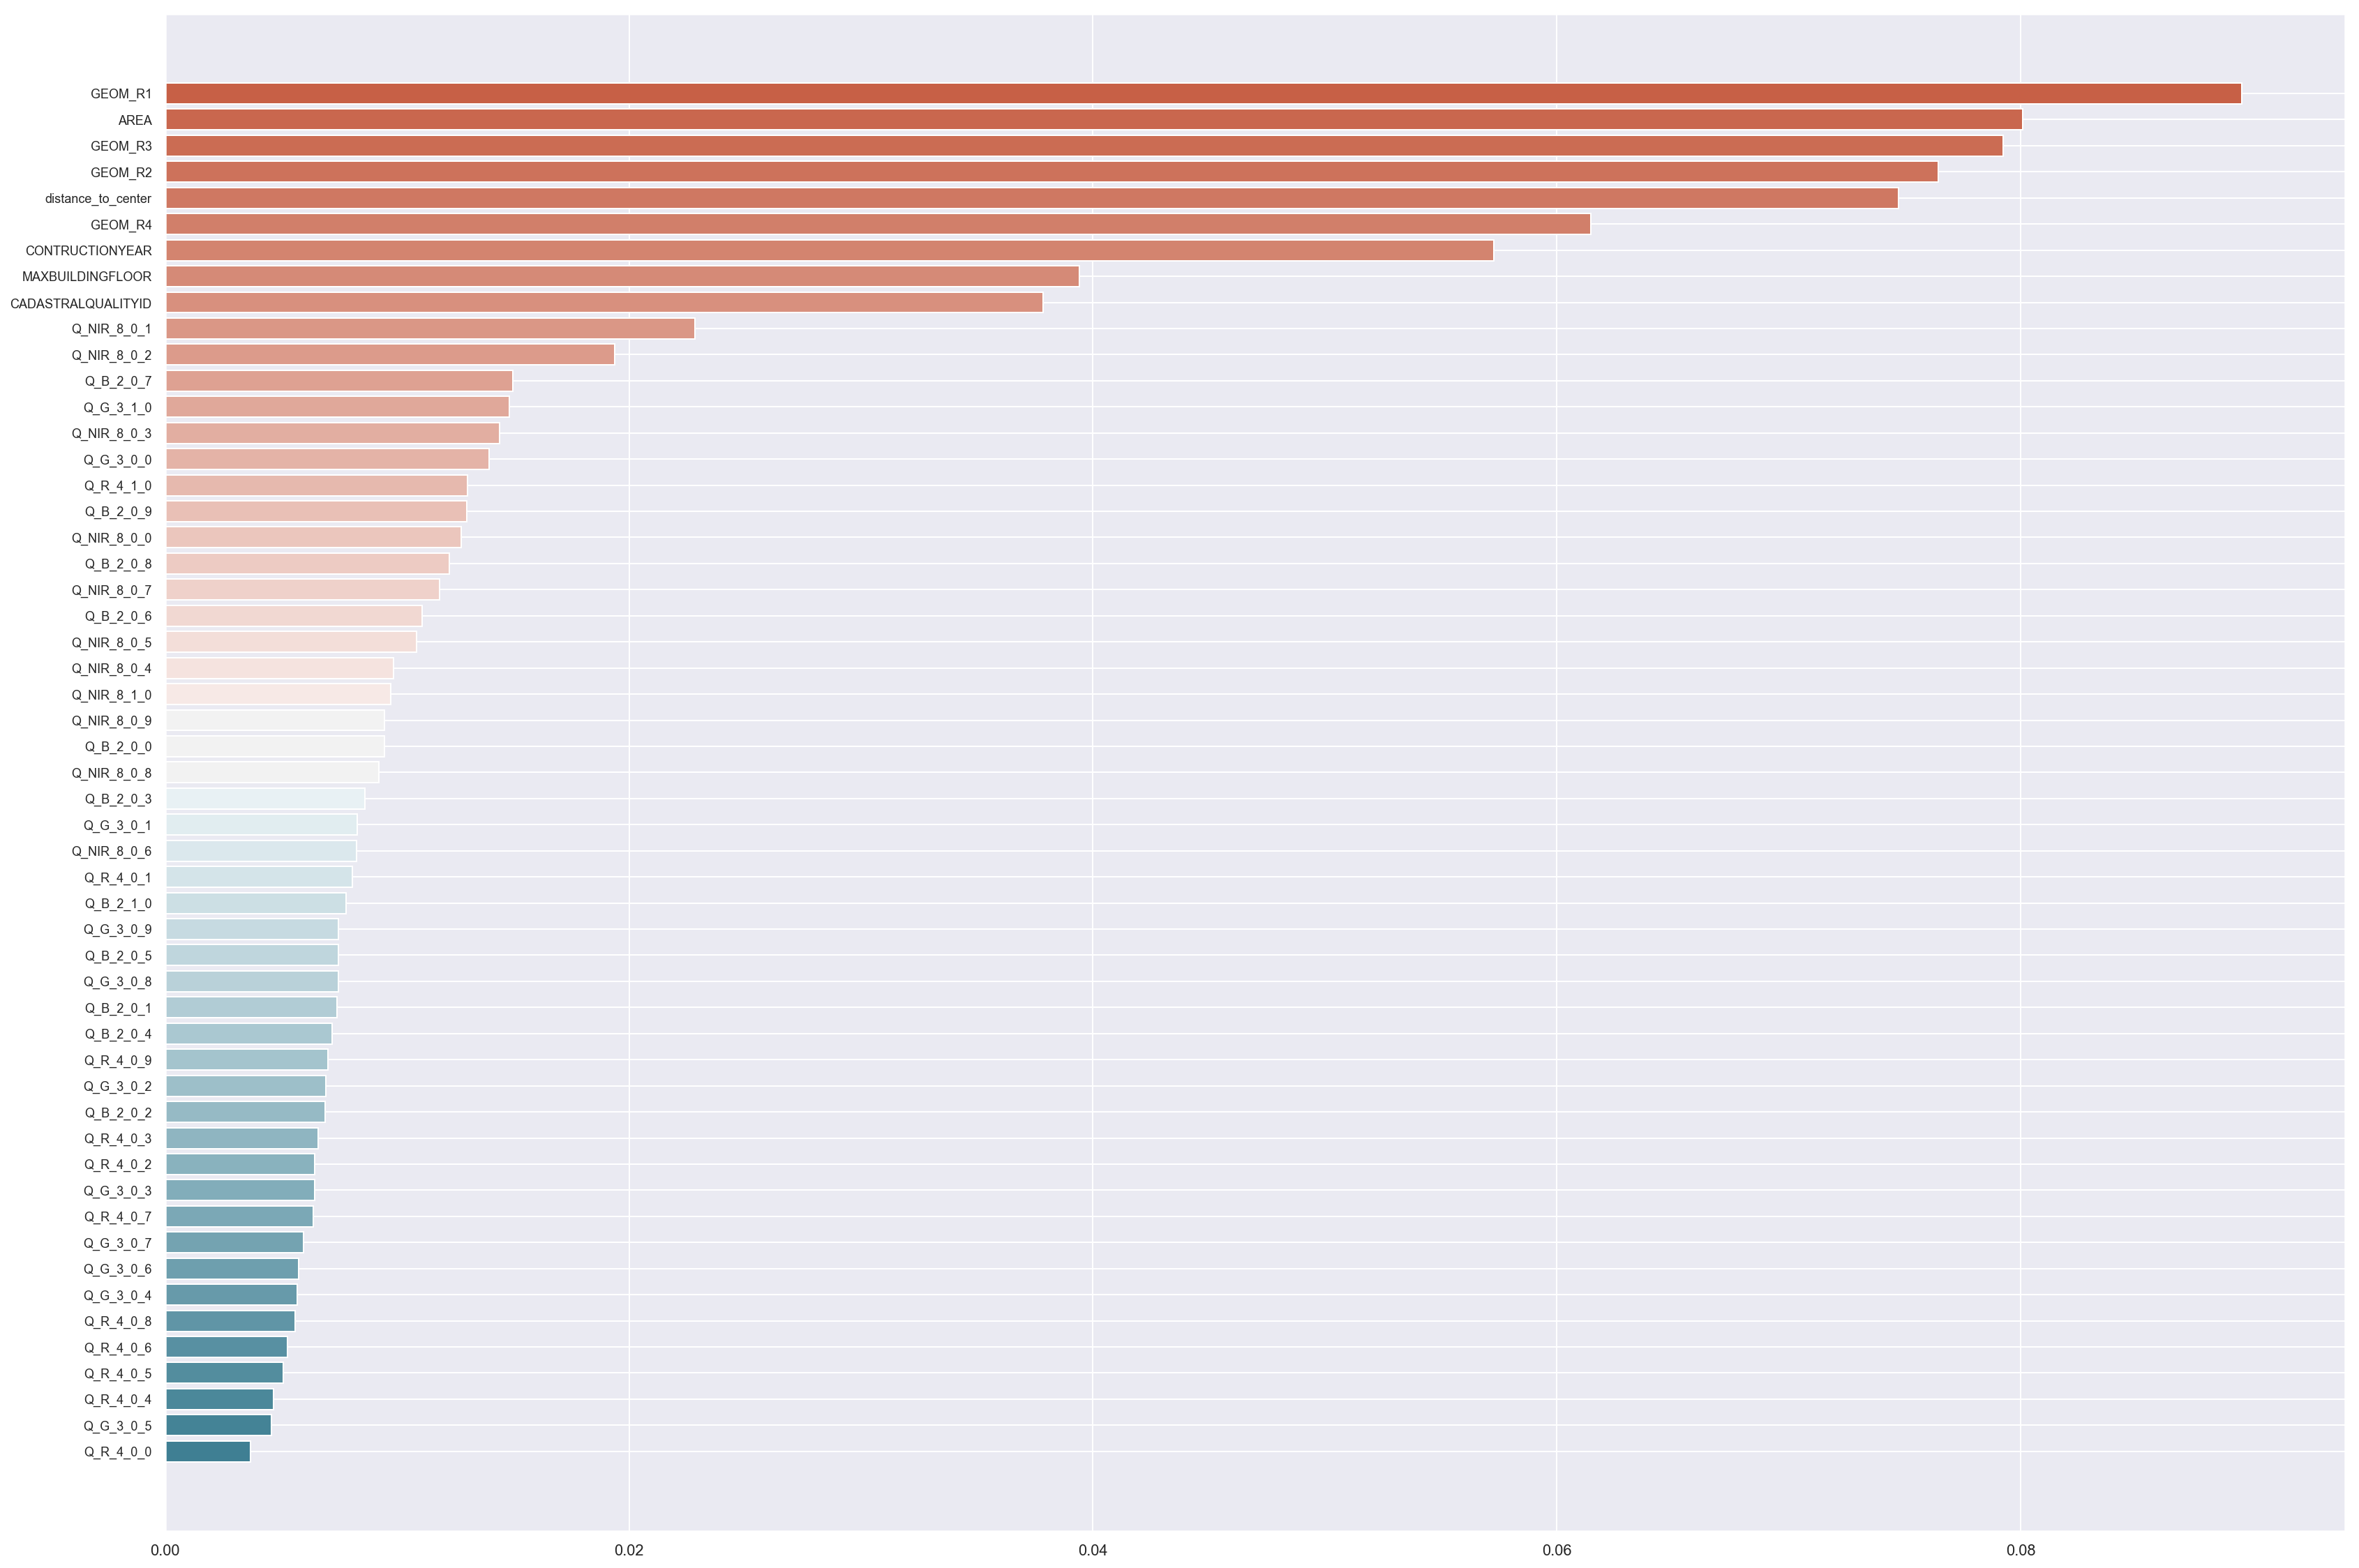

In [229]:
importances = model_multilabel['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.barh(range(df_modelar.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=55),align='center')
plt.yticks(range(df_modelar.shape[1]-2), X_test.columns[ranking], fontsize=9)
plt.show()

In [230]:
import pickle
pickle.dump(model_multilabel, open('multilabel_rfc_CCG.model', 'wb'))